In [32]:
import os
from os import listdir
import pandas as pd
path = os.getcwd()
print (listdir(path))

ori_train = pd.read_csv("train.csv")
ori_test = pd.read_csv("test.csv")

train = ori_train.copy()
test = ori_test.copy()
whole = ori_train.append(ori_test)
print (len(train), len(test), len(whole))


['Titanic 1.ipynb', 'Titanic 2.ipynb', 'README.md', 'test.csv', '.ipynb_checkpoints', 'train.csv', '.git', 'gender_submission.csv']
891 418 1309


In [33]:
print (train.isna().sum())
#too many NaN for Cabin, drop it later
print (train.Cabin.isna().sum()/len(train.Cabin))

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
0.7710437710437711


/home/bangbangjim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Age')

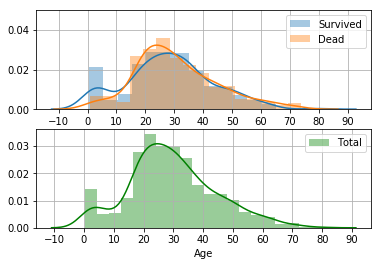

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
corr  = train[["Age", "Survived"]]
# corr = 
corr = corr.dropna()

# print (corr)
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
sns.distplot(corr.Age, hist = 1, label = "Total", ax = ax2, color = "g")
sns.distplot(corr.loc[corr["Survived"] == 1].Age, hist = 1, label = "Survived", ax = ax1)
sns.distplot(corr.loc[corr["Survived"] == 0].Age, hist = 1, label = "Dead", ax = ax1)
ax1.xaxis.set_ticks(range(-10, 100, 10))
ax2.xaxis.set_ticks(range(-10, 100, 10))
ax1.set_ylim(0,0.05)
ax2.legend()
ax1.legend()
ax2.grid()
ax1.grid()
ax2.set_xlabel("Age")



Age seems to have a little correlation with survival rate, especially the person being really young would drastically increase survivial rate. Therefore won't drop the Age column but will fill the age in somehow instead.

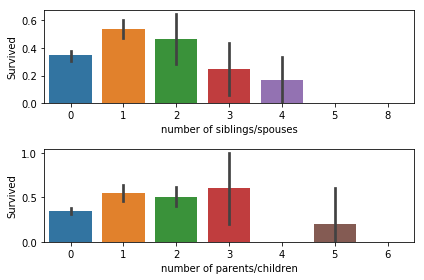

In [35]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sns.barplot(x = "SibSp", y = "Survived", data = train, ax = ax1)
sns.barplot(x = "Parch", y = "Survived", data = train, ax= ax2)
ax1.set_xlabel("number of siblings/spouses")
ax2.set_xlabel("number of parents/children")
fig.tight_layout()


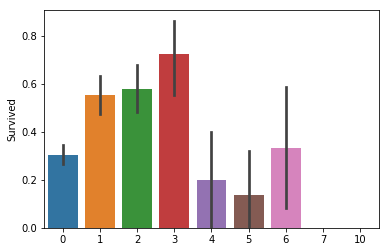

In [36]:
sns.barplot(train.SibSp + train.Parch, train.Survived)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text yticklabel objects>)

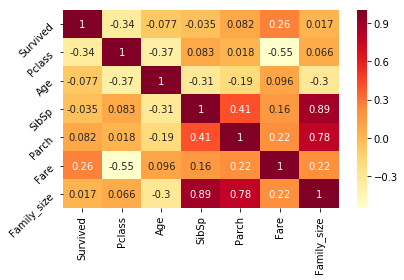

In [37]:
# wanted to use impute Age by regression but by simple observation on the correlation map it \
# doesn't appear that there is a high correlation between Age and any of the numerical variable
# so just fill in the nan with mean value for now and shouldn't have much effect on prediciton \\
# since survival chance is similar around the mean age.
# later on, worth trying turning age into age group classes and impute that with KNN. 

import numpy as np
train["Family_size"] = train.SibSp + train.Parch
corr = train.drop(["PassengerId",], axis = 1).corr()
sns.heatmap(corr, cmap = "YlOrRd", annot = True)
plt.tight_layout()
plt.yticks(rotation = 45)


heatmap doesn't show a strong correlation between family size and survived but will keep it anyway. * Decided to drop Parch and SibSp because checking logisitic regression feature importance notice that SibSp and Parch dont' make much difference.

In [38]:
train["Title"] = train.Name.str.split(",").apply(lambda x:x[1].split(".")[0].strip())
train.loc[train.Title.str.contains("Ms"), "Title"] = "Miss"
train.loc[train.Title.str.contains("Mlle"), "Title"] = "Miss"
train.loc[train.Title.str.contains("Mme"), "Title"] = "Mrs"
#Master is generally a title given to boys at the 19th Century 、
# (though some adult still carry that title since earlier days), keep it as kid tend to survive
# train.loc[train.Title.str.contains("Master"), "Title"] = "Mr"
train.loc[train.Title.str.contains("Lady"), "Title"] = "Royalty"
train.loc[train.Title.str.contains("Sir"), "Title"] = "Royalty"
train.loc[train.Title.str.contains("the Countess"), "Title"] = "Royalty"
train.loc[train.Title.str.contains("Jonkheer"), "Title"] = "Royalty"
train.loc[train.Title.str.contains("Don"), "Title"] = "Royalty"
train.loc[train.Title.str.contains("Capt"), "Title"] = "Military"
train.loc[train.Title.str.contains("Major"), "Title"] = "Military"
train.loc[train.Title.str.contains("Col"), "Title"] = "Military"
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr


In [39]:
%time
for i in range(len(train)):
    if train.at[i, "SibSp"] > 0 and train.at[i, "Parch"] == 0 \
      and pd.isna(train.at[i, "Age"]):
        #can ascertain the companions are spouse or sibling and should have similar age
#         print (train.loc[i, "Name"])
        comp = train[train.Ticket == train.iloc[i].Ticket]
#         print (comp)
        mean_age = comp.Age.mean()   
#         print (mean_age)
        train.at[i, "Age"] = mean_age
        
        
train[train.Name.str.contains("Goldenberg")]
        


CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.81 µs


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Title
453,454,1,1,"Goldenberg, Mr. Samuel L",male,49.0,1,0,17453,89.1042,C92,C,1,Mr
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,49.0,1,0,17453,89.1042,C92,C,1,Mrs


In [40]:
train[pd.isna(train.Age)].sort_values("Ticket")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Title
475,476,0,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.0000,A14,S,0,Mr
507,508,1,1,"Bradley, Mr. George (""George Arthur Brayton"")",male,NaN,0,0,111427,26.5500,NaN,S,0,Mr
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S,0,Mr
815,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0000,B102,S,0,Mr
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C,0,Dr
711,712,0,1,"Klaber, Mr. Herman",male,NaN,0,0,113028,26.5500,C124,S,0,Mr
284,285,0,1,"Smith, Mr. Richard William",male,NaN,0,0,113056,26.0000,A19,S,0,Mr
166,167,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S,1,Mrs
351,352,0,1,"Williams-Lambert, Mr. Fletcher Fellows",male,NaN,0,0,113510,35.0000,C128,S,0,Mr
185,186,0,1,"Rood, Mr. Hugh Roscoe",male,NaN,0,0,113767,50.0000,A32,S,0,Mr


In [41]:
group = train.groupby("Title")
group.mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family_size
Title,,,,,,,,
Dr,545.857143,0.428571,1.285714,42.000000,0.571429,0.000000,49.168457,0.571429
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,34.703125,3.675000
Military,615.200000,0.400000,1.000000,56.600000,0.200000,0.200000,38.020000,0.400000
Miss,411.967568,0.702703,2.291892,21.796667,0.702703,0.540541,43.800092,1.243243
Mr,454.499033,0.156673,2.410058,32.368090,0.288201,0.152805,24.441560,0.441006
Mrs,452.500000,0.793651,1.992063,36.263158,0.690476,0.825397,45.330290,1.515873
Rev,485.666667,0.000000,2.000000,43.166667,0.166667,0.166667,18.312500,0.333333
Royalty,554.200000,0.600000,1.000000,41.600000,0.400000,0.000000,42.150000,0.400000


Make sense, Miss is generally younger than Mrs, Master is usually very young and has a larger family size (board with parents). Rev has the lowest family size.

In [42]:
train.Age = train.groupby('Title').Age.apply(lambda group: group.fillna(group.mean()))

In [43]:
pd.isna(train).sum()
train.Embarked.value_counts()


S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [44]:
#both are woman, same ticket
train[pd.isna(train.Embarked)]
# print (train.groupby().count_)
train.groupby("Embarked").Fare.describe()

,count,mean,std,min,25%,50%,75%,max
Embarked,,,,,,,,
C,168.0,59.954144,83.912994,4.0125,13.69795,29.70,78.500025,512.3292
Q,77.0,13.276030,14.188047,6.7500,7.75000,7.75,15.500000,90.0000
S,644.0,27.079812,35.887993,0.0000,8.05000,13.00,27.900000,263.0000


Both are woman, same ticket number and same Fare price, So I am going to assume they embarked from the same place(probably know each other). Although at first sight it appears that their high fare price suggest they might have embarked from C, searching online revealed that Miss Icard is the maid of Mrs Stone and they boarded the ship at Southampton (https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html).

In [45]:
train.loc[pd.isna(train.Embarked), "Embarked"] = "S"

In [46]:
train.Cabin = train.Cabin.fillna("U")
train.Cabin = train.Cabin.apply(lambda x: x[0])


In [47]:
# train.drop(["Cabin", "PassengerId", "Ticket"], axis = 1, inplace = True)
train.drop(["PassengerId", "Ticket"], axis = 1, inplace = True)

In [48]:
pd.isna(train).any() # double check

Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Fare           False
Cabin          False
Embarked       False
Family_size    False
Title          False
dtype: bool

/home/bangbangjim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


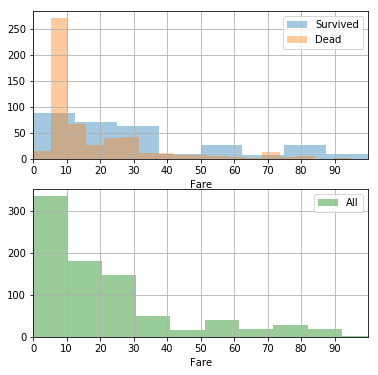

In [49]:
# sns.barplot("Pclass", "Survived", data = train)
# sns.distplot(corr.loc[corr["Survived"] == 1].Age, hist = 1, label = "Survived", ax = ax1)
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sns.distplot(train.loc[train.Survived == 1].Fare, label = "Survived", kde = 0, ax = ax1)
sns.distplot(train.loc[train.Survived == 0].Fare, label = "Dead", kde = 0, ax = ax1)
sns.distplot(train.Fare, label = "All", kde = 0, ax = ax2, color = "g")
ax1.set_xlim(0,100)
ax2.set_xlim(0,100)
ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
ax1.set_xticks(range(0,100,10))
ax2.set_xticks(range(0,100,10))
plt.show()


In [50]:
train.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_size,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,7.2500,U,S,1,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,1,0,71.2833,C,C,1,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,7.9250,U,S,0,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,53.1000,C,S,1,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,8.0500,U,S,0,Mr
5,0,3,"Moran, Mr. James",male,32.36809,0,0,8.4583,U,Q,0,Mr
6,0,1,"McCarthy, Mr. Timothy J",male,54.00000,0,0,51.8625,E,S,0,Mr
7,0,3,"Palsson, Master. Gosta Leonard",male,2.00000,3,1,21.0750,U,S,4,Master
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00000,0,2,11.1333,U,S,2,Mrs
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00000,1,0,30.0708,U,C,1,Mrs


In [51]:
train[train.Title.str.contains("Master")]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_size,Title
7,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,21.0750,U,S,4,Master
16,0,3,"Rice, Master. Eugene",male,2.000000,4,1,29.1250,U,Q,5,Master
50,0,3,"Panula, Master. Juha Niilo",male,7.000000,4,1,39.6875,U,S,5,Master
59,0,3,"Goodwin, Master. William Frederick",male,11.000000,5,2,46.9000,U,S,7,Master
63,0,3,"Skoog, Master. Harald",male,4.000000,3,2,27.9000,U,S,5,Master
65,1,3,"Moubarek, Master. Gerios",male,4.574167,1,1,15.2458,U,C,2,Master
78,1,2,"Caldwell, Master. Alden Gates",male,0.830000,0,2,29.0000,U,S,2,Master
125,1,3,"Nicola-Yarred, Master. Elias",male,12.000000,1,0,11.2417,U,C,1,Master
159,0,3,"Sage, Master. Thomas Henry",male,4.574167,8,2,69.5500,U,S,10,Master
164,0,3,"Panula, Master. Eino Viljami",male,1.000000,4,1,39.6875,U,S,5,Master


In [52]:
train.Title.value_counts()

Mr          517
Miss        185
Mrs         126
Master       40
Dr            7
Rev           6
Royalty       5
Military      5
Name: Title, dtype: int64

In [53]:
for i in train.groupby("Title"):
    print (i)

('Dr',      Survived  Pclass                           Name     Sex   Age  SibSp  \
245         0       1    Minahan, Dr. William Edward    male  44.0      2   
317         0       2           Moraweck, Dr. Ernest    male  54.0      0   
398         0       2               Pain, Dr. Alfred    male  23.0      0   
632         1       1      Stahelin-Maeglin, Dr. Max    male  32.0      0   
660         1       1  Frauenthal, Dr. Henry William    male  50.0      2   
766         0       1      Brewe, Dr. Arthur Jackson    male  42.0      0   
796         1       1    Leader, Dr. Alice (Farnham)  female  49.0      0   

     Parch      Fare Cabin Embarked  Family_size Title  
245      0   90.0000     C        Q            2    Dr  
317      0   14.0000     U        S            0    Dr  
398      0   10.5000     U        S            0    Dr  
632      0   30.5000     B        C            0    Dr  
660      0  133.6500     U        S            2    Dr  
766      0   39.6000     U        

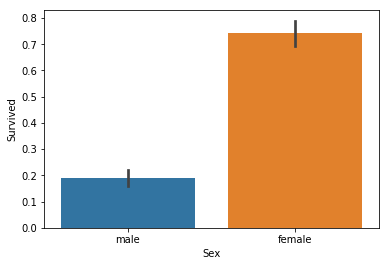

In [54]:
sns.barplot("Sex", "Survived", data = train)

In [55]:
X = train.drop(["Survived", "Name", ], axis = 1)
y = train.Survived
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked',
       'Family_size', 'Title'],
      dtype='object')

In [56]:
# X = pd.get_dummies(X, columns = ["Title", "Sex", "SibSp", "Parch", "Family_size", "Embarked"])

X.drop(["SibSp", "Parch"], axis = 1, inplace = True)
X = pd.get_dummies(X, columns = ["Cabin", "Title", "Sex","Family_size", "Embarked"])

# X.drop(["Family_size"], axis = 1, inplace = True)
# X = pd.get_dummies(X, columns = ["Title", "Sex", "SibSp", "Parch", "Embarked"])

# X.drop(["Family_size", "SibSp", "Parch"], axis = 1, inplace = True)
# X = pd.get_dummies(X, columns = ["Title", "Sex", "Embarked"])

In [57]:
from sklearn import preprocessing
columns = X.columns
X = preprocessing.scale(X)

In [58]:
# X.drop("Fare", axis = 1, inplace = True)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size = 0.2, random_state = 100)
clf = LogisticRegression(C = 10)
cross_val_score(clf, X, y, cv = 5).mean()

0.8193629873462074

In [59]:
clf.fit(train_X, train_y)
def feat_imp(coef):
    feature_im = pd.DataFrame(data = coef, columns = ["importance"], index = columns).sort_values("importance", ascending = False)
    return feature_im
feature_im = feat_imp(clf.coef_[0])
    
    # feature_im = pd.DataFrame(data = (clf.coef_[0]), columns = ["importance"], index = train_X.columns).sort_values("importance", ascending = False)

In [60]:
feature_im.head(10)

,importance
Sex_female,0.977797
Title_Master,0.776550
Family_size_0,0.286906
Fare,0.258181
Cabin_E,0.206240
Cabin_D,0.162087
Family_size_1,0.151602
Title_Mr,0.110685
Title_Military,0.082839
Cabin_B,0.070078


In [61]:
feature_im.tail(10)

,importance
Cabin_T,-0.204027
Family_size_4,-0.293404
Title_Miss,-0.385338
Title_Rev,-0.390115
Age,-0.403280
Family_size_5,-0.410956
Family_size_10,-0.576509
Family_size_7,-0.616864
Pclass,-0.677276
Sex_male,-0.977797


In [84]:
from sklearn.linear_model import SGDClassifier
svm = SGDClassifier()
svm.fit(train_X, train_y)
cross_val_score(svm, X, y, cv = 5).mean()

/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/

0.7330965778620868

In [87]:
feature_im = feat_imp(svm.coef_[0])
feature_im.head(10)
feature_im.head(-10)

,importance
Family_size_3,22.308164
Title_Master,18.332429
Sex_female,13.248898
Cabin_E,9.247749
Family_size_2,9.046439
Fare,8.539026
Title_Mrs,7.248728
Cabin_B,6.706988
Embarked_S,3.192344
Cabin_T,-0.441150


In [82]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='adam', alpha=1e-3,hidden_layer_sizes=(100,), random_state=100,learning_rate_init = 0.01 )
cross_val_score(nn, X, y, cv = 5).mean()

0.8014606422399989

In [64]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, oob_score = True)
# cross_val_score(rf, X, y, cv = 5).mean()

In [65]:
rf.fit(X, y)
rf.oob_score_

0.8013468013468014

In [66]:
feature_im = feat_imp(rf.feature_importances_)

In [67]:
feature_im.head(10)

,importance
Fare,0.215080
Age,0.211311
Title_Mr,0.091035
Sex_male,0.082581
Sex_female,0.077834
Pclass,0.067377
Cabin_U,0.033541
Title_Mrs,0.026716
Title_Miss,0.024855
Family_size_2,0.018652


In [68]:
feature_im.tail(10)

,importance
Family_size_10,0.003257
Cabin_A,0.002896
Family_size_7,0.002888
Title_Military,0.002612
Cabin_F,0.002607
Cabin_G,0.001603
Title_Dr,0.001448
Title_Rev,0.001319
Title_Royalty,0.000992
Cabin_T,0.000232


In [69]:
rf.oob_score_

0.8013468013468014

In [70]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_jobs = -1, n_estimators = 500, learning_rate = 0.05, max_depth = 3, colsample_bytree = 1, colsample_bylevel = 0.5)
xgb.fit(train_X, train_y)
xgb.score(val_X, val_y)

/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8324022346368715

In [71]:
cross_val_score(xgb, X, y, cv = 5).mean()

/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of

0.8350934662795453

In [72]:
feature_im = feat_imp(xgb.feature_importances_)
feature_im.head(10)


,importance
Age,0.304431
Fare,0.299083
Pclass,0.046982
Cabin_U,0.027120
Sex_female,0.027120
Title_Mr,0.025974
Title_Mrs,0.025210
Cabin_E,0.024828
Family_size_0,0.022154
Family_size_2,0.021008


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
cross_val_score(knn, X, y, cv = 5).mean()

In [97]:
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier([("log", clf), ("mlp", nn), ("xgb", xgb)],  n_jobs = -1, voting = "soft")
vc.fit(train_X, train_y)
print(vc.score(val_X, val_y))
print (cross_val_score(vc, X, y, cv = 5).mean())

0.8324022346368715


/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of

0.8260982833100515


/home/bangbangjim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [74]:
pd.isna(test).sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

0.7902055722648555